# 5) Application de modèles d'apprentissage supervisé

Dans la partie précédente, nous avons utilisé des modèles d'apprentissage non-superviés afin de dégager les mots les plus utilisés dans les mails. Depuis ces mots, nous avons classer nos mails en 4 thèmes: Meetings (si le mail évoque les mots "meeting" ou "presenter"), Business Trip (si le mail évoque les mots "flying", "traveling" ou "trip") , Hobby ( pour les mots "ski", "golf", "boat"), ou Autre pour les autres mails.

Dans cette partie, nous allons appliquer des modèles d'apprentissage supervisé pour le thème d'un mail en s'appuyant sur les variables que nous avons créées : Moment,Day,Month,subject_size,content_size,forwarded_mail,nb_cc
Nous comparerons l'efficacité de nos modèles à l'aide de deux indicateurs, l'accuracy (taux de justesse) et le recall (rappel) en priorisant ce dernier



In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import time
dataset = pd.read_csv('/Users/pierreperrin/Desktop/IG4/semestre7/Projet_DataScience/dataset_cleaned.csv',
                      dtype={"content": str},low_memory=False)
df = dataset[['Moment','Day','Month','subject_size','content_size','forwarded_mail','nb_cc','Meetings']]

## Classer un mail en "Meetings"
Nous allons ici prédir si un mail évoque une réunion en utilisant différents modèles non-supervisés. On sépare donc notre jeu de données en 2. Une partie qui va nous servir à apprendre à nos modèles à classer correctement si mail concerne une réunion (X_train, y_train) et une partie qui va nous permettre à tester notre modèle (X_test,y_test).

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
X = df.drop(['Meetings'], axis=1)
y = df['Meetings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Modèle 1 : KNeighborsClassifier

In [29]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.842

Le modèle des KNeighborsClassifier prédit qu'un mail concerne une réunion un taux de justesse de 84%
La métric que l'on décide de choisir pour tester notre modèle est le recall puisque que l'on a à peu près 20 % (un peu moins) de mails qui appartiennent aux thème meeting et 80% non. De ce fait si on regardait la métrique accuracy, cela ne serait pas pertinent puisque notre modele n'a qu'a attribuer la classe non meeting a tout les mails et il aura une accuracy de 80%.

In [14]:
kfold = StratifiedKFold(n_splits=20, random_state=1, shuffle=True)
cv_results = cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=kfold, scoring='recall')
print("recall :",cv_results.mean())

notre recall est peu satsfaisant dans ce cas

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

model1 = KNeighborsClassifier()
model1 = model1.fit(X_train, y_train)
predictions1 = model1.predict(X_test)

print(accuracy_score(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))

0.84295
[[15427  1045]
 [ 2096  1432]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     16472
           1       0.58      0.41      0.48      3528

    accuracy                           0.84     20000
   macro avg       0.73      0.67      0.69     20000
weighted avg       0.83      0.84      0.83     20000



### Amélioration du modèle des KNeighborsClassifier

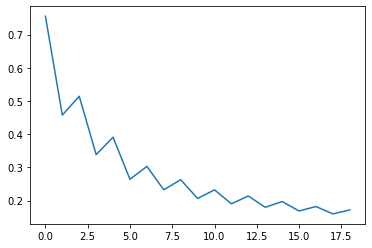

In [17]:
val_score = []
for k in range(1,20):
    score = cross_val_score(KNeighborsClassifier(k), X_train, y_train, cv = kfold, scoring='recall').mean()
    val_score.append(score)

plt.plot(val_score)

ce graphe ne permet pas de dégager de valeur particulière pour le paramètre k de la fonction KNeighborsClassifier pour lequel le score serait plus important 

In [18]:
param_grid = {'n_neighbors': np.arange(1,20), 'metric': ['euclidean', 'manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [19]:
grid.best_score_

0.9005625000000002

In [20]:
grid.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [21]:
model = grid.best_estimator_
model.score(X_test, y_test)

0.9186

In [22]:
confusion_matrix(y_test, model.predict(X_test))

array([[15656,   816],
       [  812,  2716]])

On a donc réussis à ameliorer notre model en regardant cette matrice de confusion

In [23]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     16472
           1       0.77      0.77      0.77      3528

    accuracy                           0.92     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.92      0.92      0.92     20000



Finalement, après amélioration le modèle KNeighborsClassifier permet de classer si un mail concerne une réunion avec un taux de 
justesse de 0,92. Un rappel pour classer un mail comme de 0,77 pour vrai et 0,95 pour faux. Ces résultats sont globalement satisfaisant et le modèle nous parait éfficace pour classer la modalité Meetings d'un mail.


### Modèle 2 : Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

kfold = StratifiedKFold(n_splits=20, random_state=1, shuffle=True)
cv_results = cross_val_score(DecisionTreeClassifier(), X_train, y_train, cv=kfold, scoring='recall')
print("recall :",cv_results.mean())


recall : 0.7485712311675221


In [34]:
model2 = tree.DecisionTreeClassifier()
model2 = model2.fit(X_train, y_train)
predictions2 = model2.predict(X_test)

print(accuracy_score(y_test, predictions2))
print(confusion_matrix(y_test, predictions2))
print(classification_report(y_test, predictions2))

#max_depth
#tree.plot_tree(model2) 

0.90895
[[15551   958]
 [  863  2628]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     16509
           1       0.73      0.75      0.74      3491

    accuracy                           0.91     20000
   macro avg       0.84      0.85      0.84     20000
weighted avg       0.91      0.91      0.91     20000



L'arbre de décision a un taux de justesse de 0.90, a un rappel de 0,94 pour l'étiquette faux et 0,75 pour l'étiquette vrai. Ces résultats nous semble également satisfaisant pour prevoir la modalité Meetings d'un mail.

### Modèle 3 : SVC

In [24]:
from sklearn.svm import LinearSVC

kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
cv_results = cross_val_score(LinearSVC(), X_train, y_train, cv=kfold, scoring='recall')
print("recall :",cv_results.mean())


/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


recall : 0.11932833154698105


/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [25]:
model3 = LinearSVC()
model3 = model3.fit(X_train, y_train)
predictions3 = model3.predict(X_test)

print(accuracy_score(y_test, predictions3))
print(confusion_matrix(y_test, predictions3))
print(classification_report(y_test, predictions3))

0.8291
[[16403    69]
 [ 3349   179]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     16472
           1       0.72      0.05      0.09      3528

    accuracy                           0.83     20000
   macro avg       0.78      0.52      0.50     20000
weighted avg       0.81      0.83      0.76     20000



/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Le modèle SVC a un taux de justesse de 0.82, un rappel de 1 pour l'étiquette faux et 0.05 pour l'étiquette vrai. Le modèle a tendance classer tout les mails comme faux. Ces résultats ne nous semble pas assez satisfaisant pour classer la modalité Meetings d'un mail.

# Classer un mail en "Business Trip"

In [ ]:
df = dataset[['Moment','subject_size','content_size','forwarded_mail','nb_cc','Meetings']]

### Modèle 1 : KNeighborsClassifier

In [54]:
model_Business_trip = KNeighborsClassifier()
model_Business_trip.fit(X_train, y_train)
model_Business_trip.score(X_test, y_test)

0.842

In [55]:
df2 = dataset[['Moment','Day','Month','subject_size','content_size','forwarded_mail','nb_cc','Business_trip']]

In [57]:
X = df2.drop(['Business_trip'], axis=1)
y = df2['Business_trip']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [59]:
model2_1 = KNeighborsClassifier()
model2_1.fit(X_train, y_train)
model2_1.score(X_test, y_test)

0.9324

In [60]:
kfold = StratifiedKFold(n_splits=20, random_state=1, shuffle=True)
cv_results = cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=kfold, scoring='recall')

In [61]:
print("recall :",cv_results.mean())

recall : 0.31980157809236487


In [62]:
predictions2_1 = model2_1.predict(X_test)

print(accuracy_score(y_test, predictions2_1))
print(confusion_matrix(y_test, predictions2_1))
print(classification_report(y_test, predictions2_1))

0.9324
[[18199   446]
 [  906   449]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     18645
           1       0.50      0.33      0.40      1355

    accuracy                           0.93     20000
   macro avg       0.73      0.65      0.68     20000
weighted avg       0.92      0.93      0.93     20000



Le modèle KNeighborsClassifier a un taux de justesse de 0.93, a un rappel de 0,98 pour l'étiquette faux mais seulement  0,33 pour l'étiquette vrai. Ces résultats sont insatifaisant pour le classer un mail en Business Trip 

In [64]:
param_grid = {'n_neighbors': np.arange(1,20), 'metric': ['euclidean', 'manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [65]:
grid.best_score_

0.9567875000000001

In [66]:
grid.best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

In [67]:
model = grid.best_estimator_
model.score(X_test, y_test)

0.96495

In [68]:
confusion_matrix(y_test, model.predict(X_test))

array([[18289,   356],
       [  345,  1010]])

# Colonne thèmes

In [85]:
#on va classer les mails par theme, pour cela on etablit on ordre d'importance lorsque 
#le mail parle de différent theme puisque on la le classer que dans un seul theme

def theme(dataset):
    
    dataset['theme'] = None
    
    for i in range(len(dataset.content)):
        if (dataset['Meetings'][i]==1):
            dataset['theme'][i] = "meeting"
        elif (dataset['Business_trip'][i]==1):
            dataset['theme'][i] = "business trip"
        elif(dataset['hobby'][i]==1):
            dataset['theme'][i] = "hobby"
        else:
            dataset['theme'][i] = "autre"

            
theme(dataset)

<ipython-input-85-250e5694e806>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['theme'][i] = "autre"
<ipython-input-85-250e5694e806>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['theme'][i] = "meeting"
<ipython-input-85-250e5694e806>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['theme'][i] = "hobby"
<ipython-input-85-250e5694e806>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [96]:
print(dataset[dataset['theme']=="meeting"].shape)
print(dataset[dataset['theme']=="business trip"].shape)
print(dataset[dataset['theme']=="hobby"].shape)
print(dataset[dataset['theme']=="autre"].shape)

(17523, 30)
(4804, 30)
(10312, 30)
(67361, 30)


# Classification des mails par thèmes :

In [97]:
df3 = dataset[['Moment','Day','Month','subject_size','content_size','forwarded_mail','nb_cc','theme']]

In [ ]:
X = df2.drop(['theme'], axis=1)
y = df2['theme']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [99]:
model3_1 = KNeighborsClassifier()
model3_1.fit(X_train, y_train)
model3_1.score(X_test, y_test)

0.93305

In [100]:
kfold = StratifiedKFold(n_splits=20, random_state=1, shuffle=True)
cv_results = cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=kfold, scoring='recall')

In [101]:
print("recall :",cv_results.mean())

recall : 0.3146399009824398


In [102]:
predictions3_1 = model3_1.predict(X_test)

print(accuracy_score(y_test, predictions2_1))
print(confusion_matrix(y_test, predictions2_1))
print(classification_report(y_test, predictions2_1))

0.8953
[[17834   823]
 [ 1271    72]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     18657
           1       0.08      0.05      0.06      1343

    accuracy                           0.90     20000
   macro avg       0.51      0.50      0.50     20000
weighted avg       0.88      0.90      0.89     20000



#### Le recall est trop petit la methode des KNNeighbours n'est pas bonne pour cette classification

#### on va essayer decision tree 

# Decision tree

In [103]:
kfold = StratifiedKFold(n_splits=20, random_state=1, shuffle=True)
cv_results = cross_val_score(DecisionTreeClassifier(), X_train, y_train, cv=kfold, scoring='recall')
print("recall :",cv_results.mean())

recall : 0.7527900260436813


In [104]:
model3_2 = tree.DecisionTreeClassifier()
model3_2 = model3_2.fit(X_train, y_train)
predictions3_2 = model3_2.predict(X_test)

print(accuracy_score(y_test, predictions3_2))
print(confusion_matrix(y_test, predictions3_2))
print(classification_report(y_test, predictions3_2))

0.96365
[[18244   413]
 [  314  1029]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18657
           1       0.71      0.77      0.74      1343

    accuracy                           0.96     20000
   macro avg       0.85      0.87      0.86     20000
weighted avg       0.96      0.96      0.96     20000



## on va essayer d'ameliorer

In [105]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:   50.3s finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

DecisionTreeClassifier(max_leaf_nodes=98, random_state=42)

In [107]:
model3_2 = grid_search_cv.best_estimator_
model3_2.score(X_test, y_test)

0.9401

In [108]:
confusion_matrix(y_test, model3_2.predict(X_test))

array([[18567,    90],
       [ 1108,   235]])